In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import xlsxwriter
from PIL import Image
import os
from PIL.ExifTags import TAGS
import piexif
import random
from os import listdir
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
#read in excel files
xls18 = pd.ExcelFile('NHL 2017-18.xls')
season18 = pd.read_excel(xls18, 'TOT',header=2)
#xls17 = pd.ExcelFile('NHL 2016-17.xls')
#season17 = pd.read_excel(xls17, 'All Sits',header=2)
#shots=pd.read_csv("shots_2017.csv")

In [3]:
season18=season18[season18.columns[~season18.columns.isin(["TOI.1","TOI.2","TOI.3","iCF.1","iCF.2","iFF.1","iHF.1","iPENT2",
                                                  "iPENT5","iPEND2","iPEND5",'CF.1','CA.1','FF.1','FA.1','SF.1','SA.1'
                                                  ,'GF.1','GA.1','GP.1', 'G.1', 'A.1', 'PTS.1', '+/-.1','PIM.1',
                                                  'TOI.4', 'OPS.1', 'DPS.1', 'PS.1','A1'])]]

In [4]:
season18=season18[season18['Cap Hit']>1000000]
season18=season18.reset_index(drop=True)

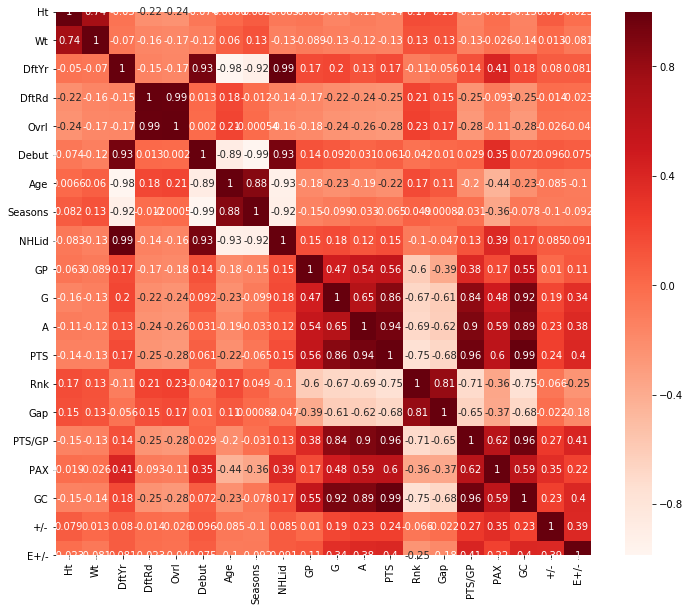

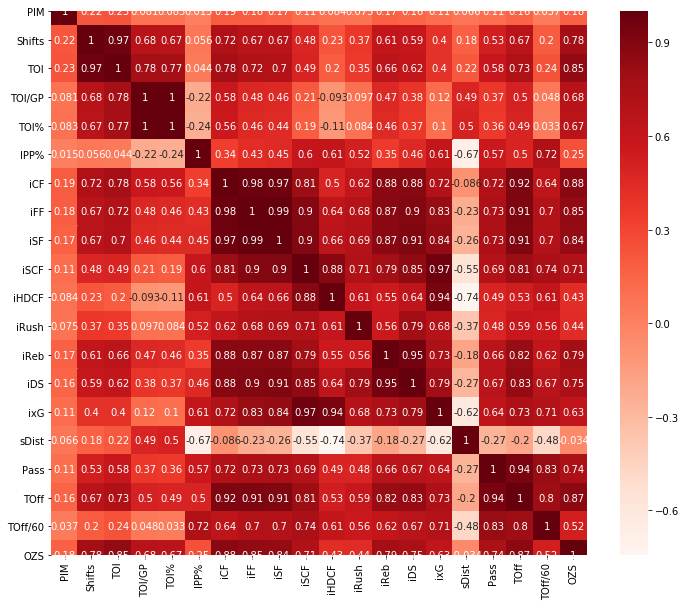

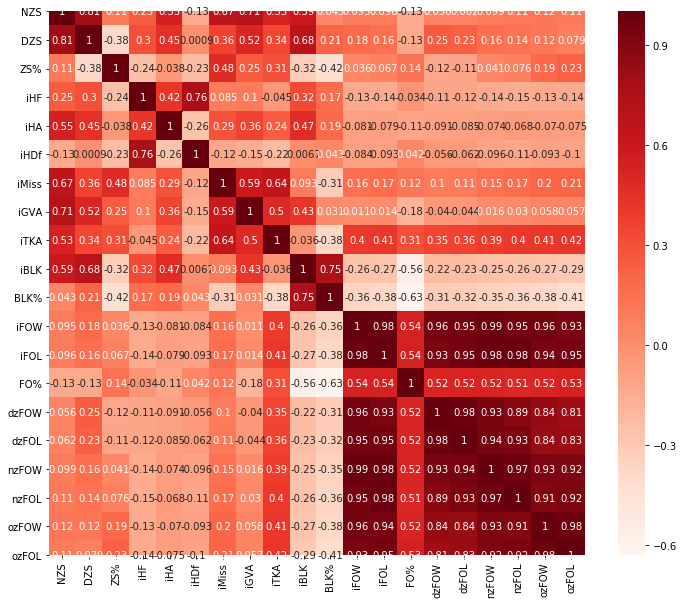

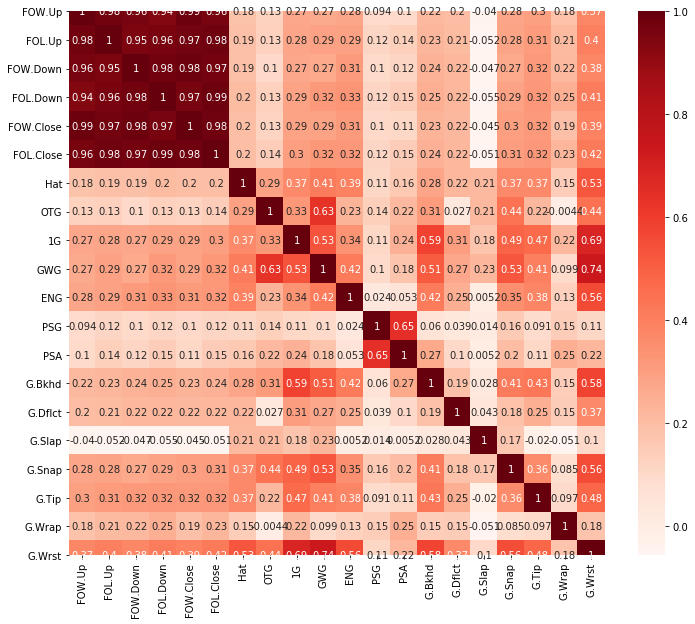

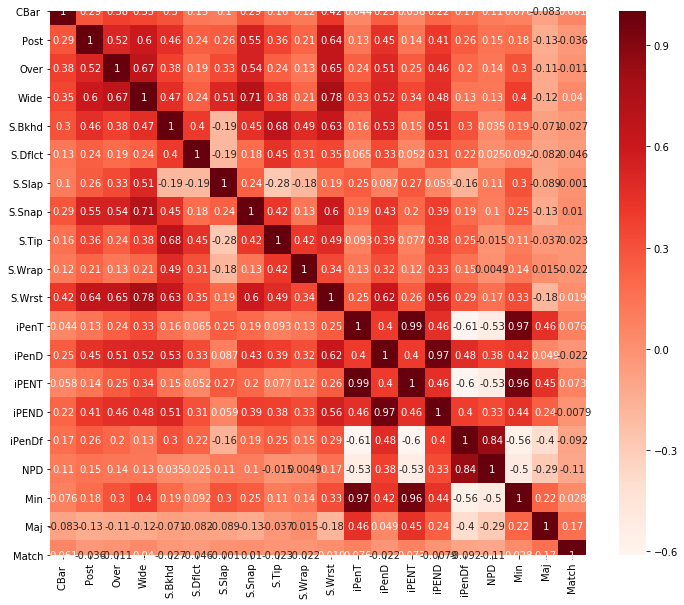

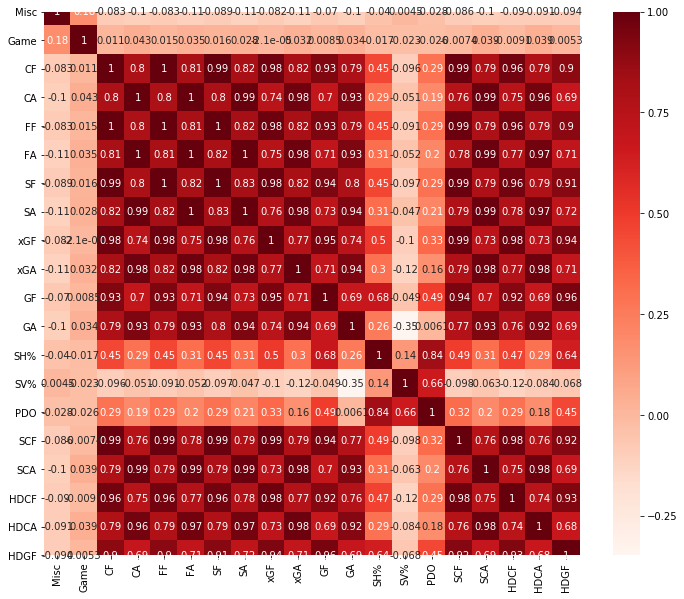

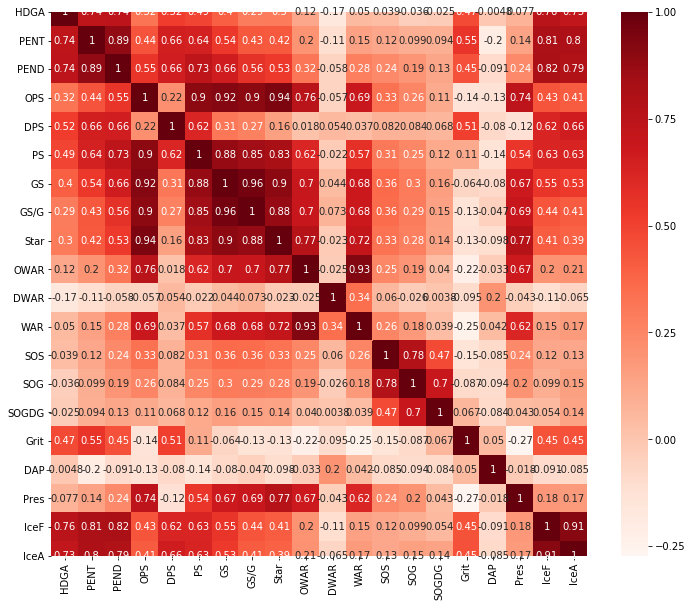

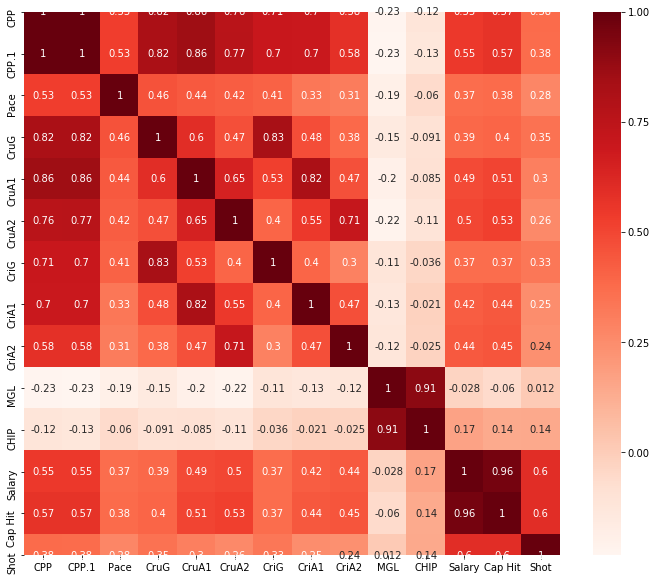

In [5]:
corr = season18.corr()
for i in range(0,int(season18.shape[1]/20)):
    plt.figure(figsize=(12,10))
    sns.heatmap(corr.loc[corr.columns[i*20:i*20+20],corr.columns[i*20:i*20+20]], annot=True, cmap=plt.cm.Reds)
    plt.show()

In [6]:
modelSeason18=season18.copy()
modelSeason18.reset_index(drop=True,inplace=True)

In [7]:
names=modelSeason18['CorsicaID']

In [8]:
modelSeason18.drop(modelSeason18.columns[modelSeason18.dtypes=='object'], axis=1, inplace=True)
modelSeason18.drop(['Born'], axis=1, inplace=True)

In [9]:
modelSeason18.shape

(395, 154)

In [10]:
modelSeason18.fillna('?',inplace=True)

In [11]:
for col in modelSeason18.columns:
    if modelSeason18[col].dtype == object:
        count = 0
        count = [count + 1 for x in modelSeason18[col] if x == '?']
        print(col + ' ' + str(sum(count)))

DftYr 36
DftRd 36
Ovrl 36
SOS 228
SOG 228
SOGDG 228
MGL 131
CHIP 131


In [12]:
modelSeason18.drop(['SOS','SOG','SOGDG','MGL','CHIP','Salary'], axis=1, inplace=True)

In [13]:
for column in modelSeason18.columns:
    modelSeason18.loc[modelSeason18[column] == '?', column] = np.nan
modelSeason18.dropna(axis = 0, inplace = True)
modelSeason18X=modelSeason18.drop(['Cap Hit','NHLid'], axis=1)
modelSeason18Y=modelSeason18[['Cap Hit']]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


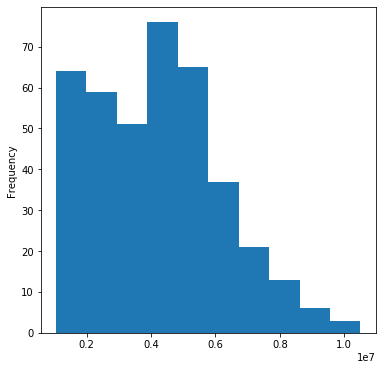

In [14]:
fig = plt.figure(figsize=(6,6)) # define plot area
ax = fig.gca()
season18['Cap Hit'].plot.hist(ax = ax, bins = 10)

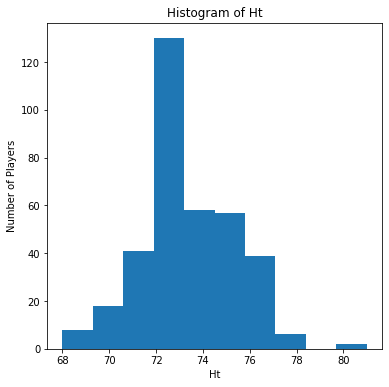

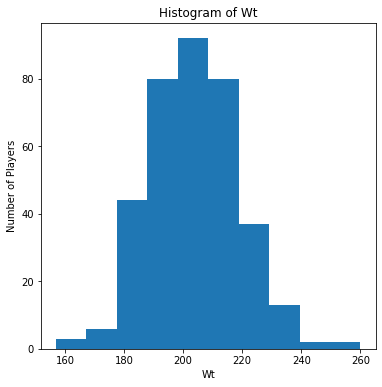

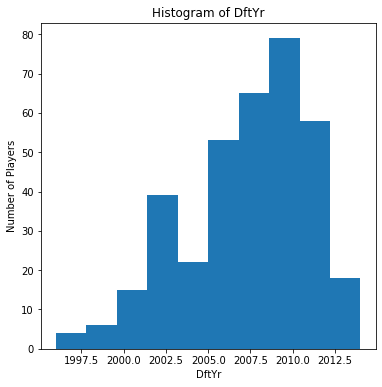

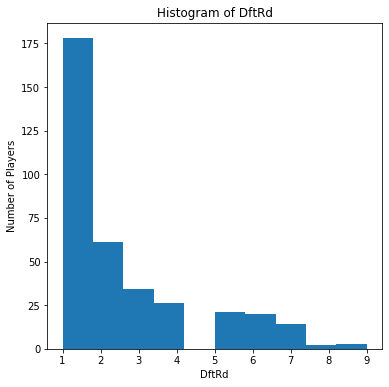

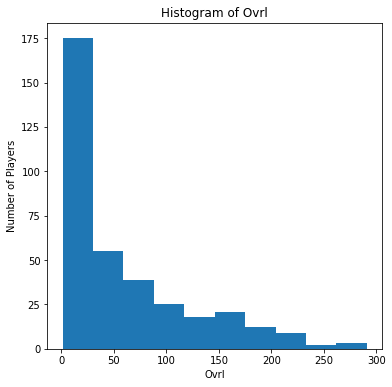

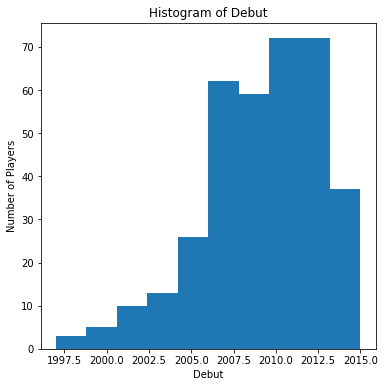

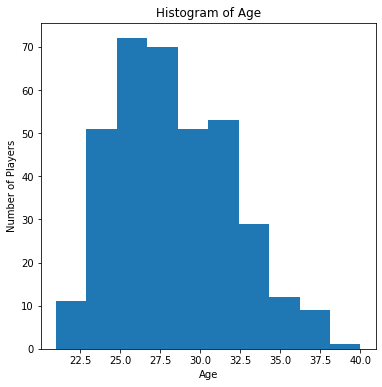

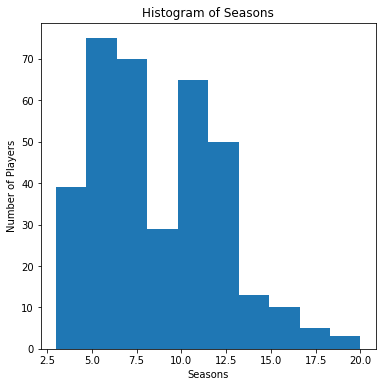

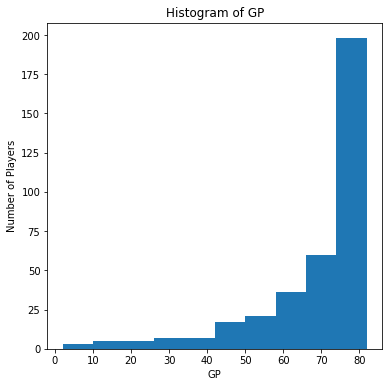

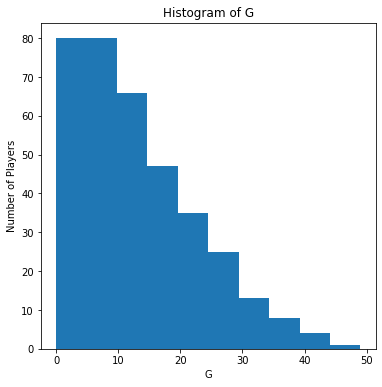

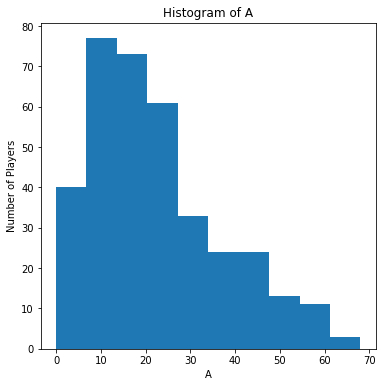

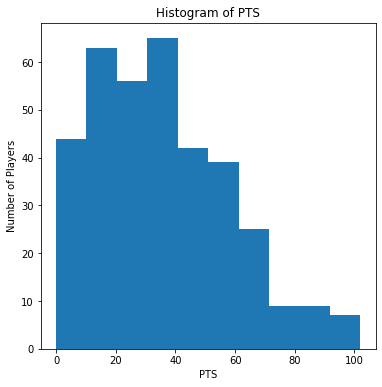

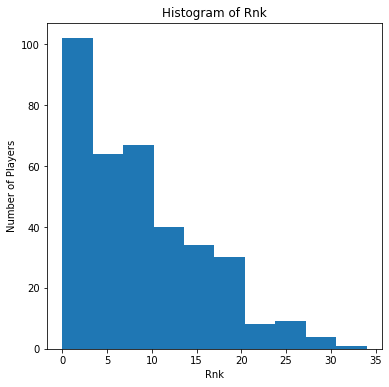

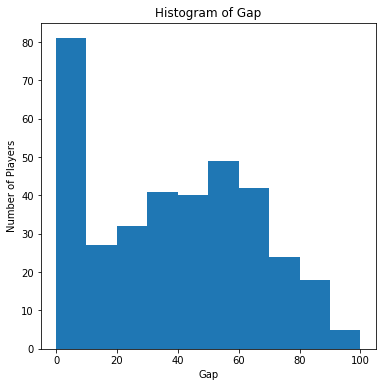

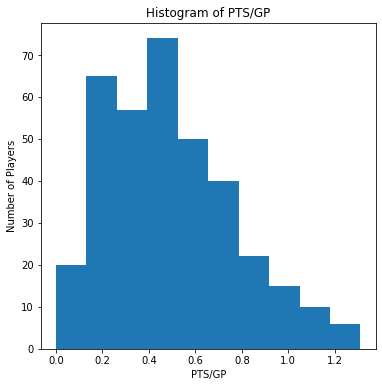

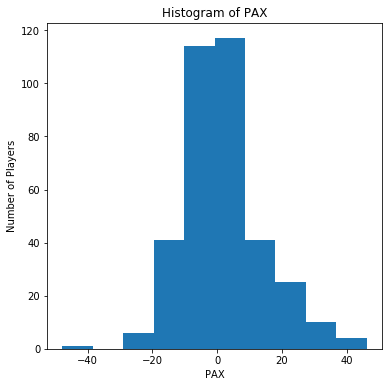

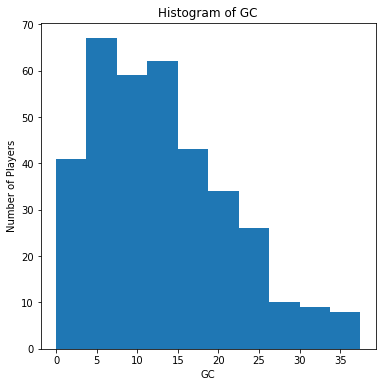

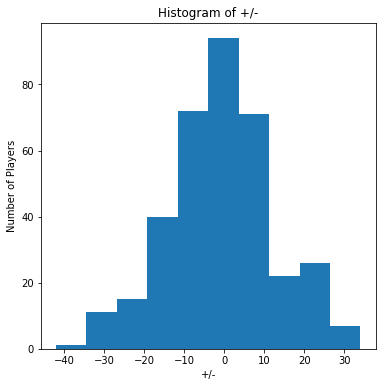

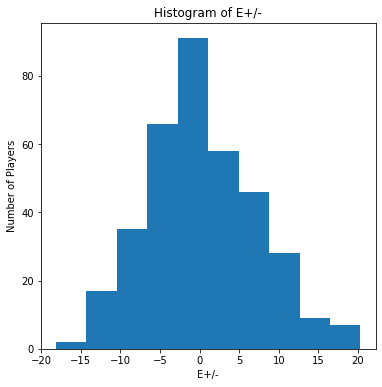

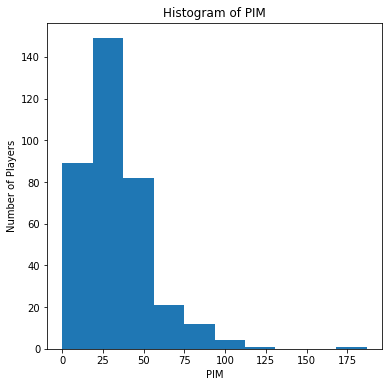

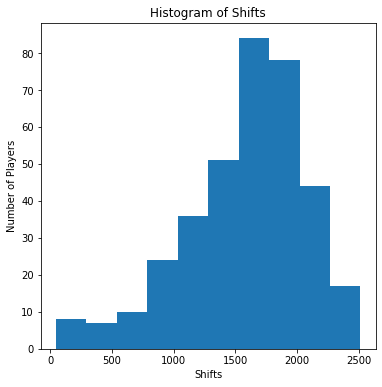

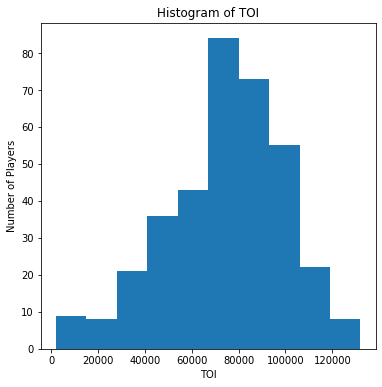

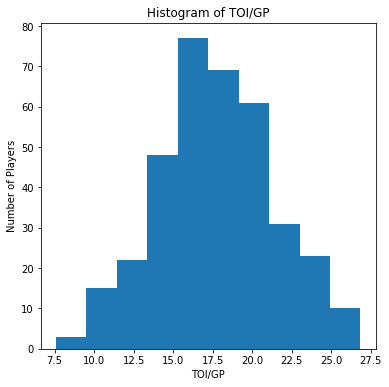

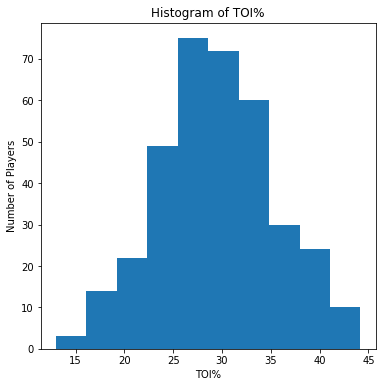

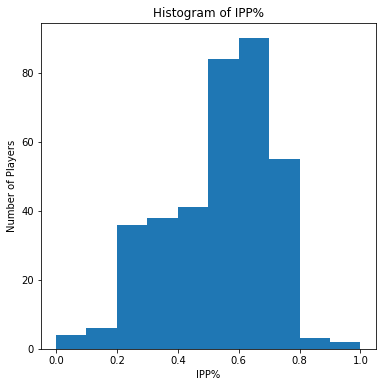

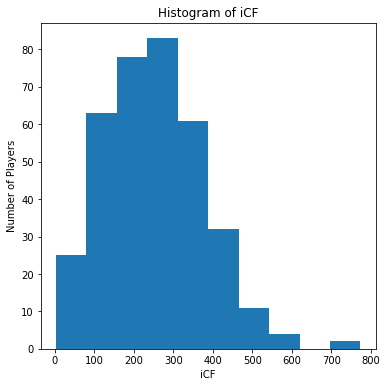

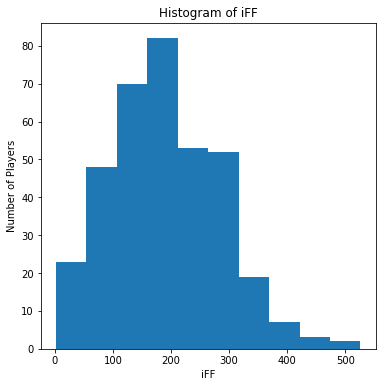

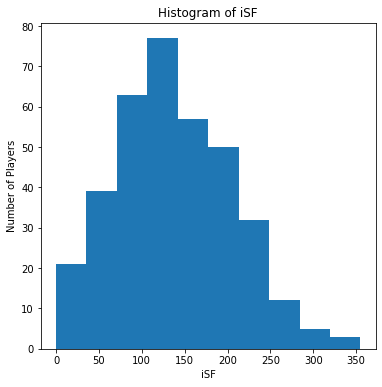

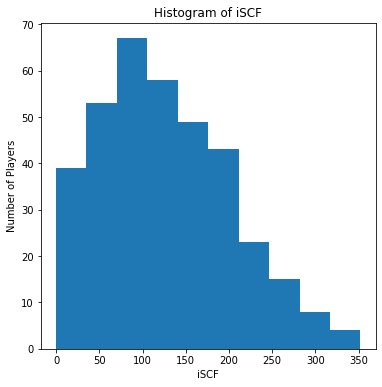

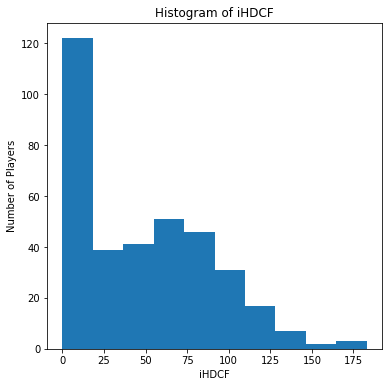

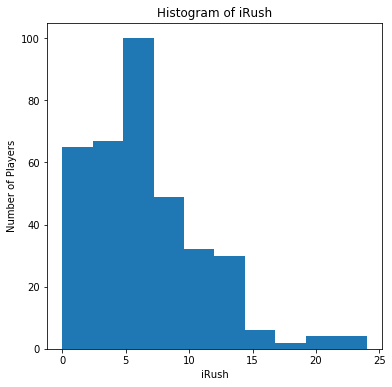

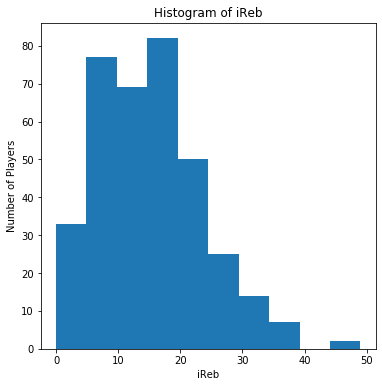

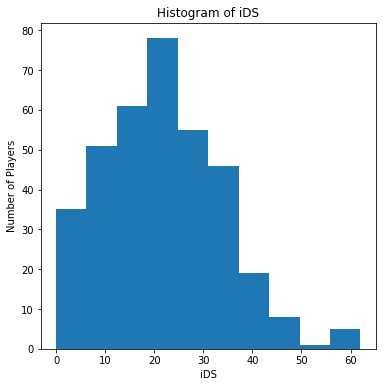

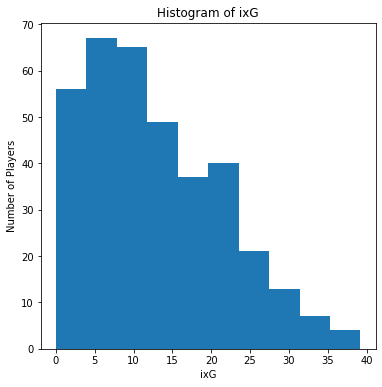

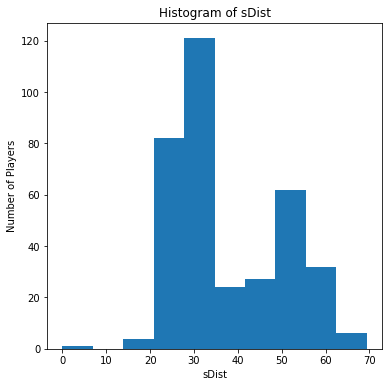

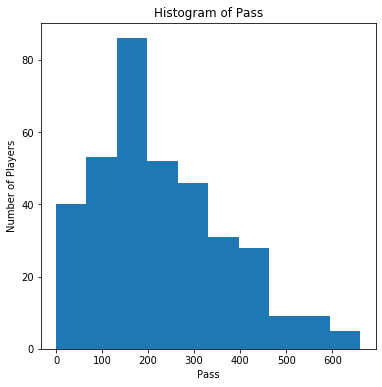

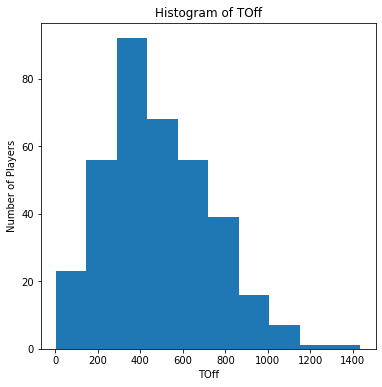

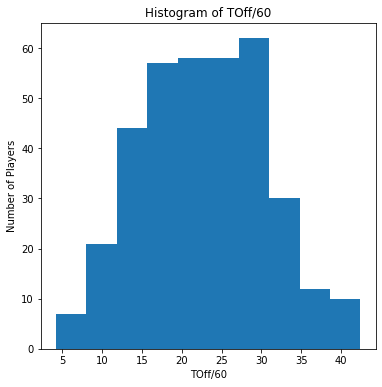

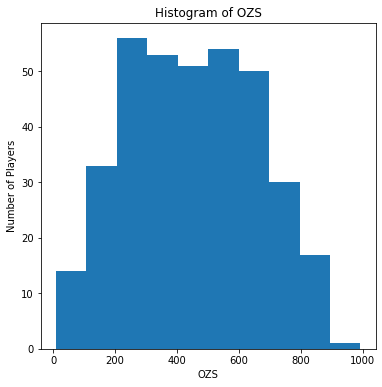

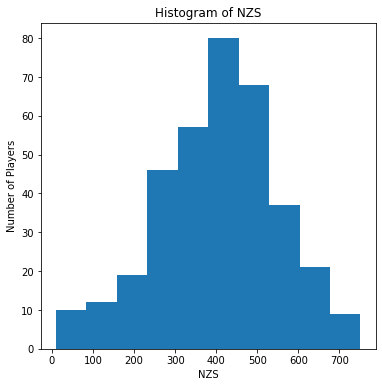

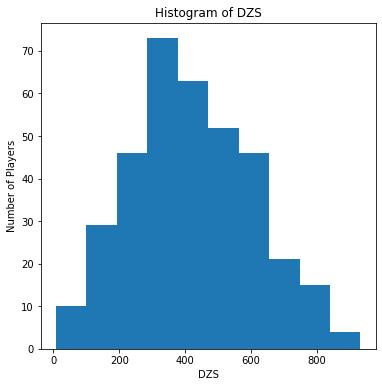

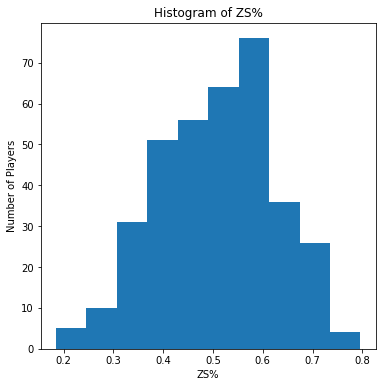

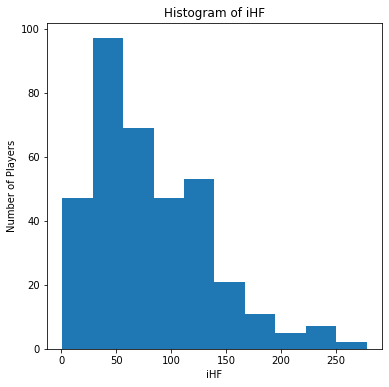

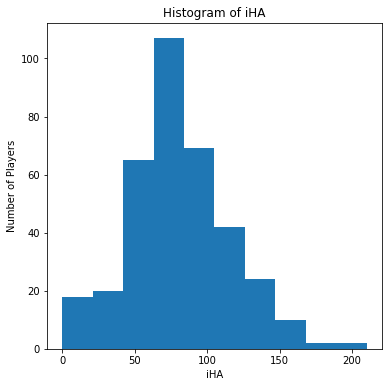

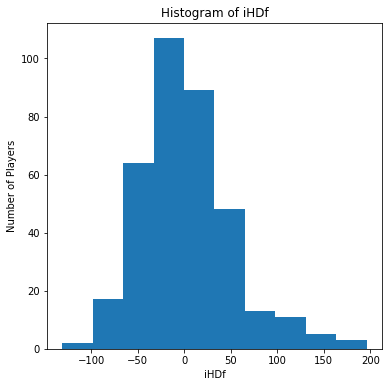

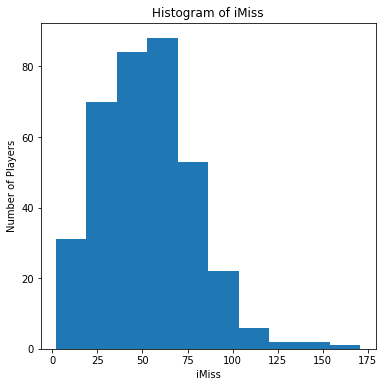

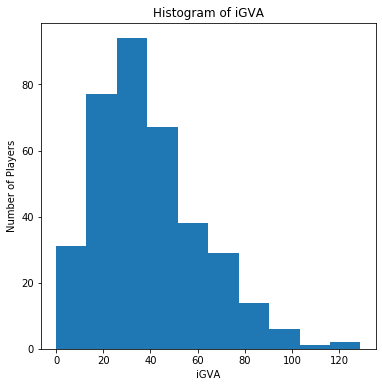

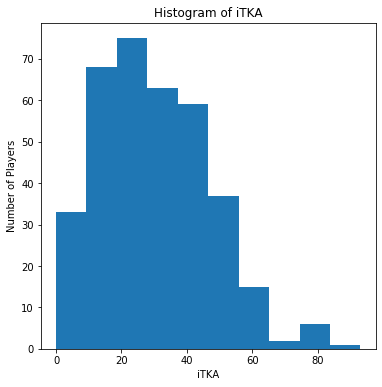

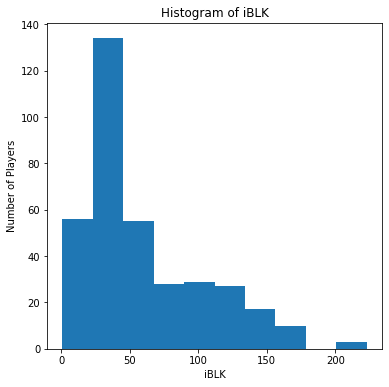

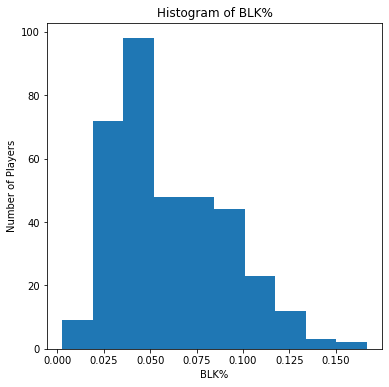

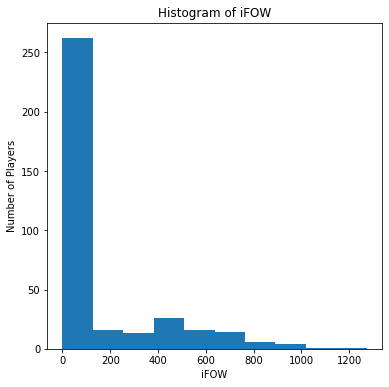

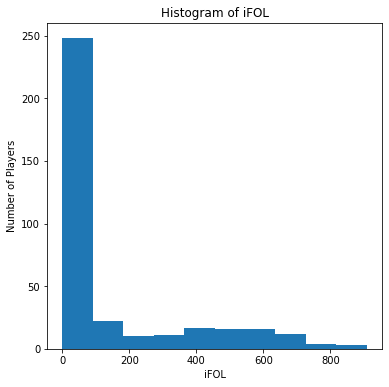

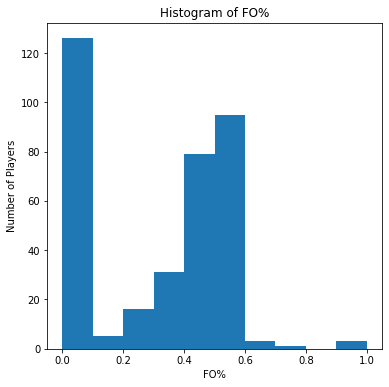

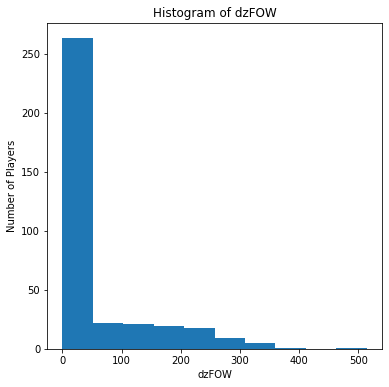

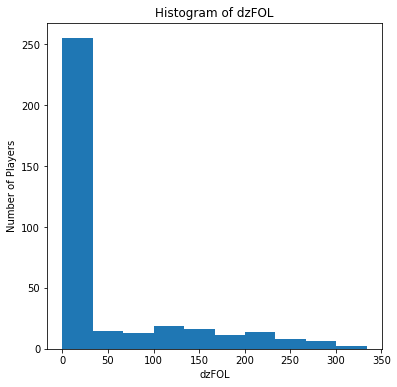

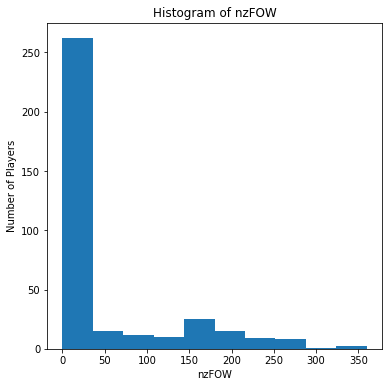

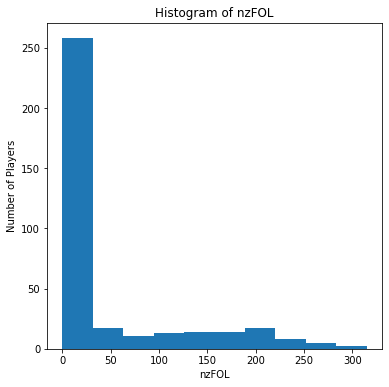

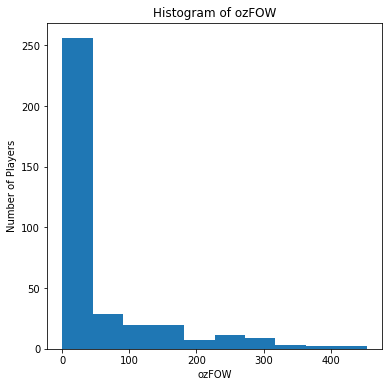

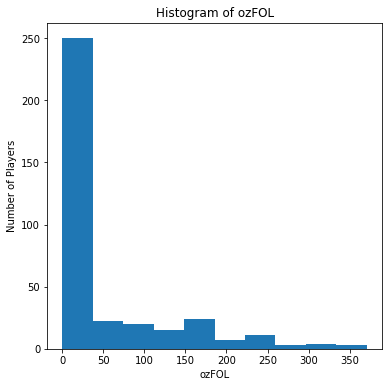

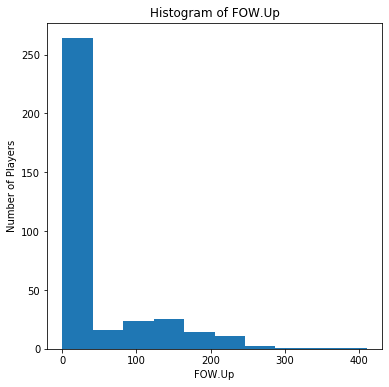

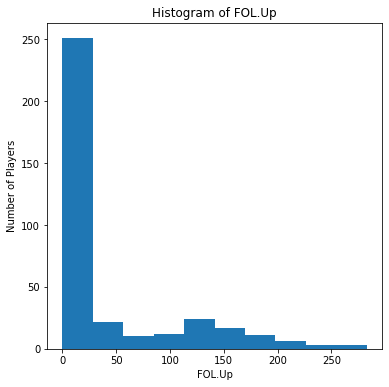

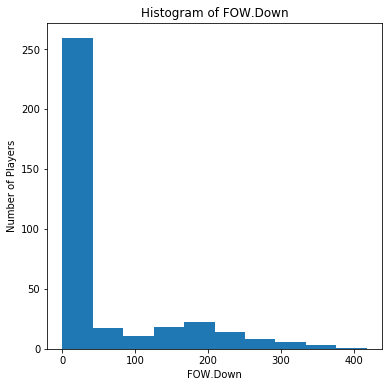

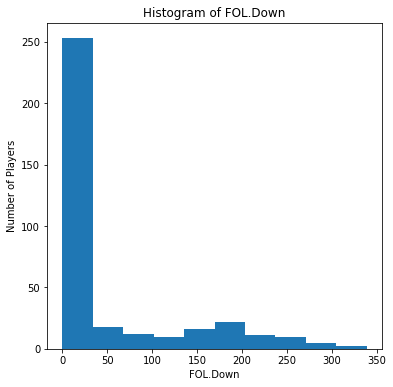

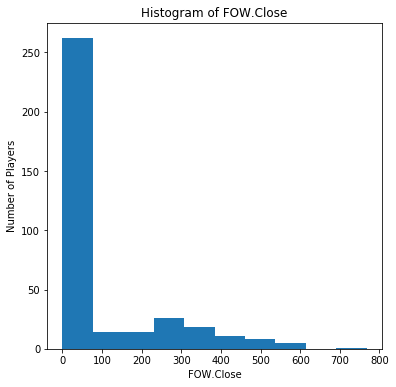

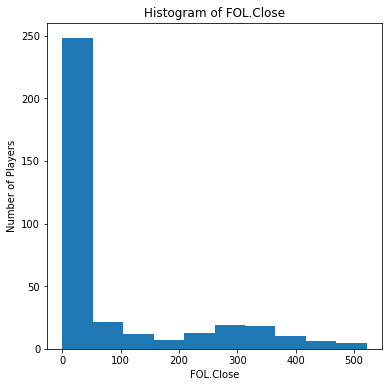

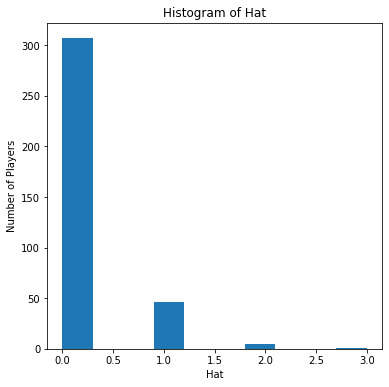

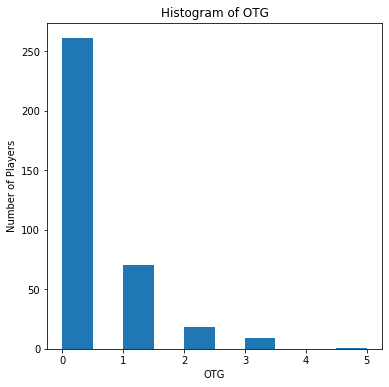

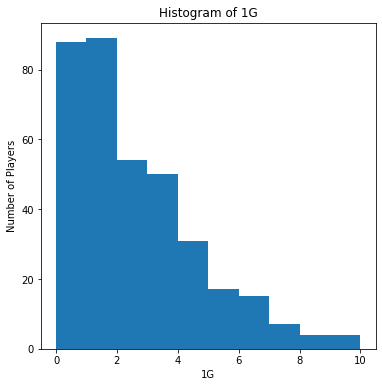

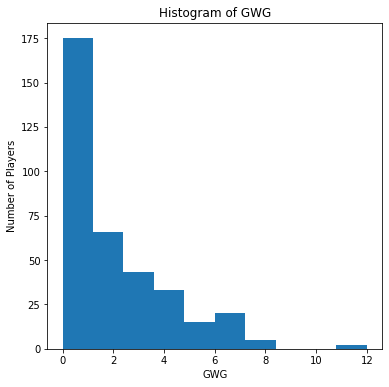

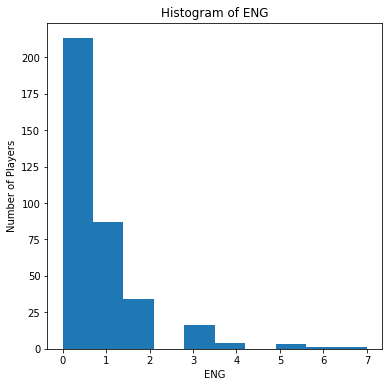

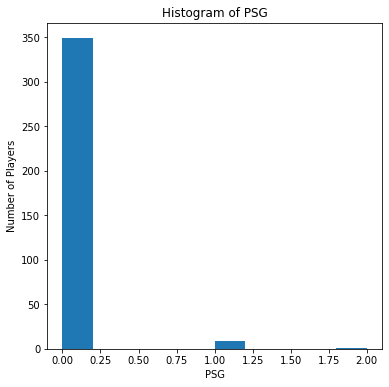

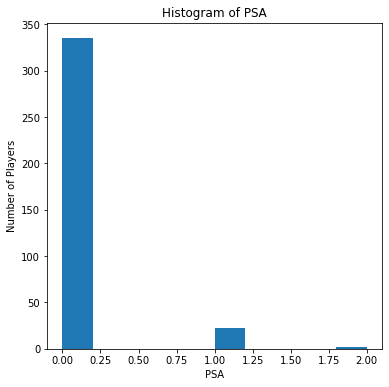

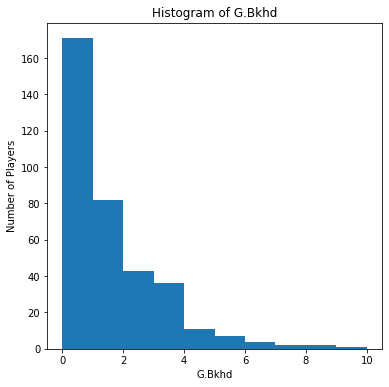

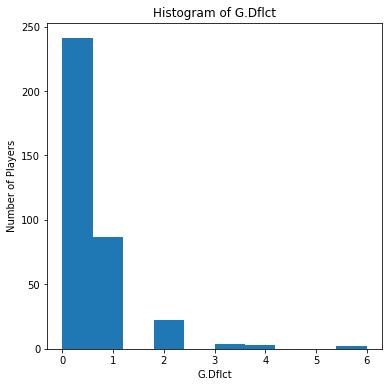

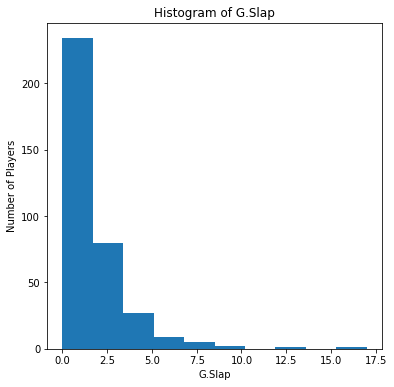

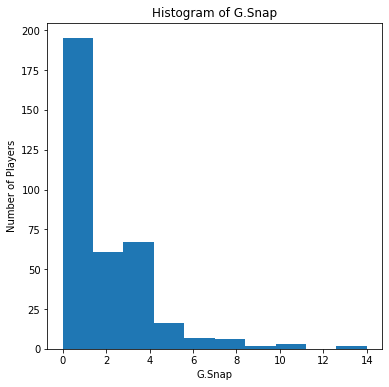

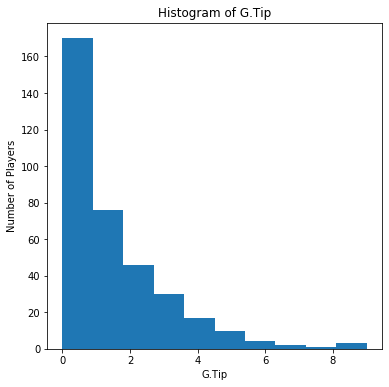

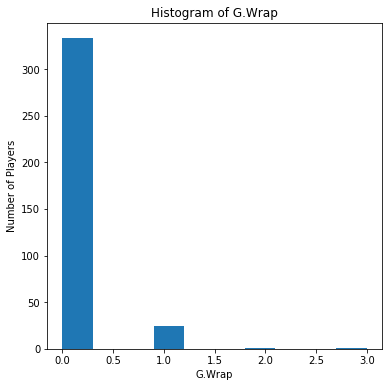

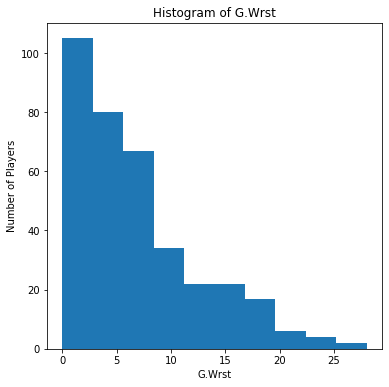

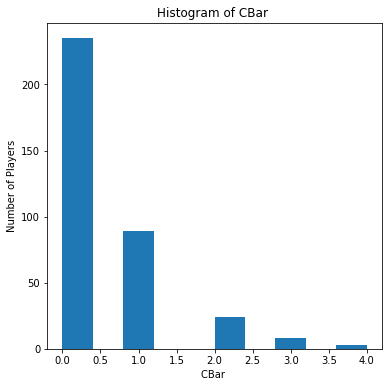

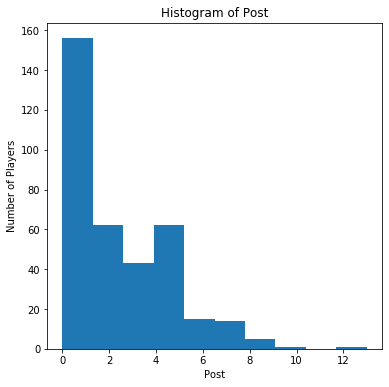

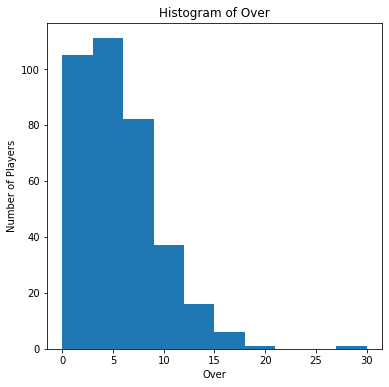

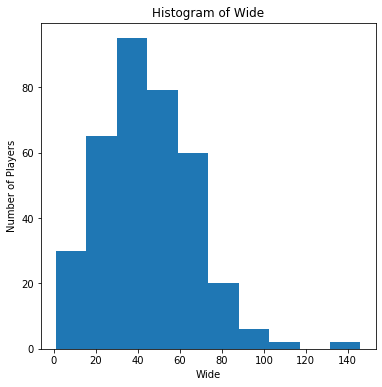

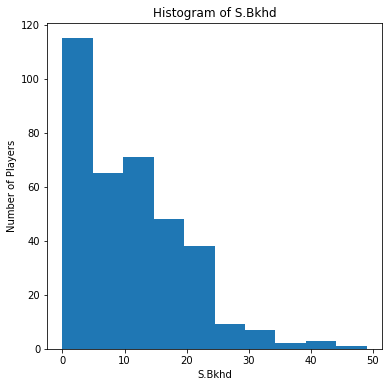

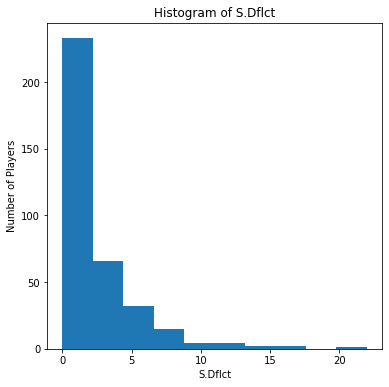

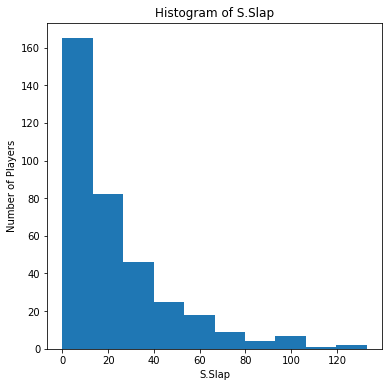

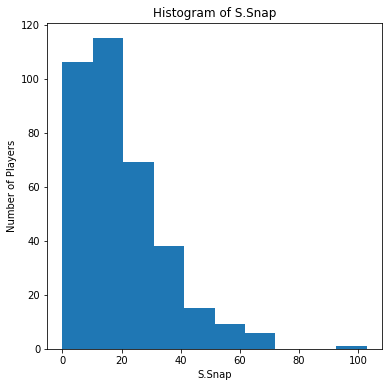

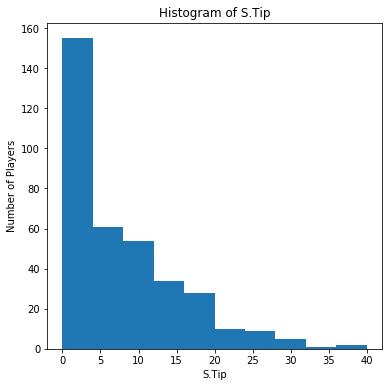

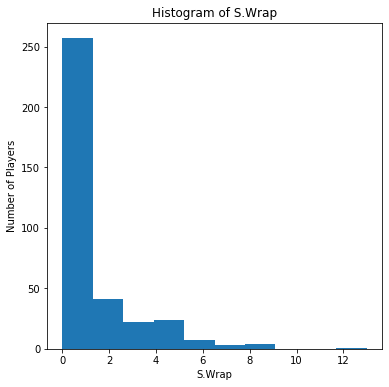

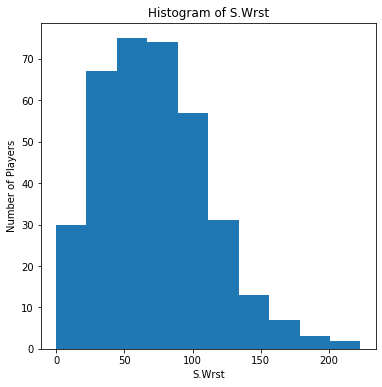

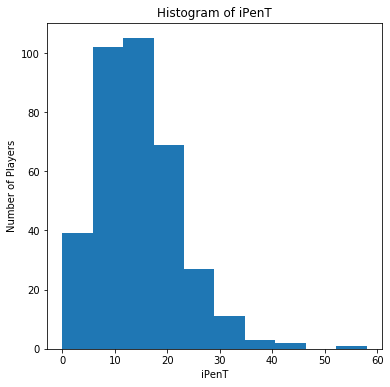

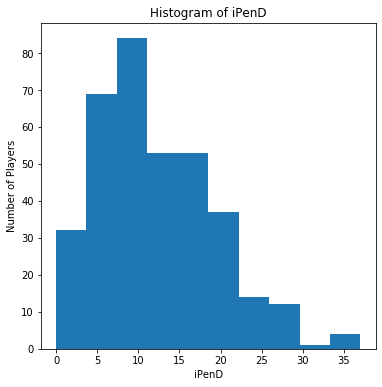

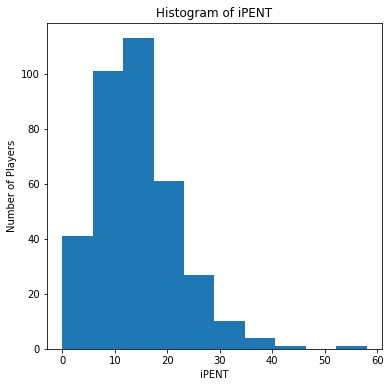

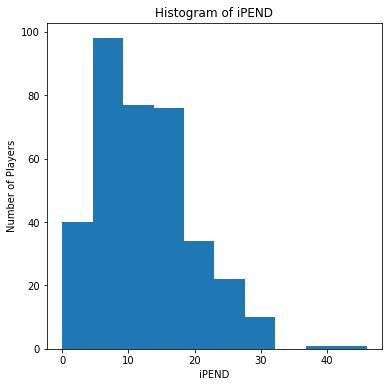

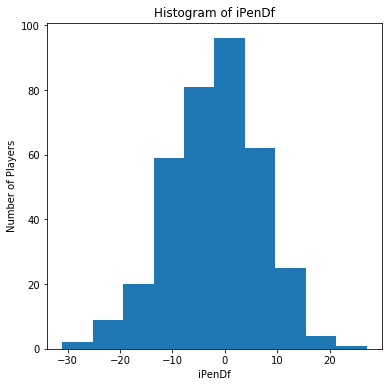

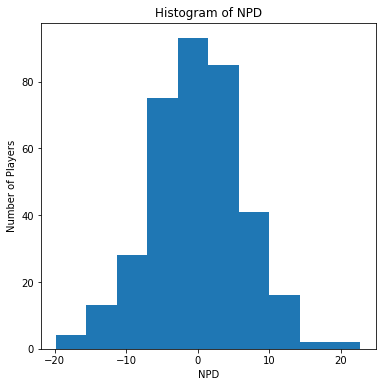

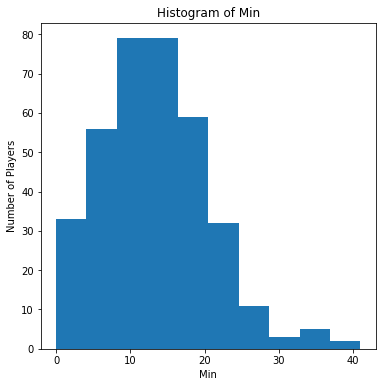

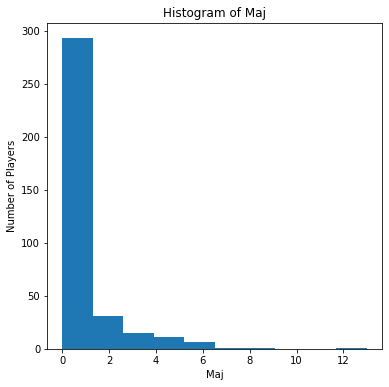

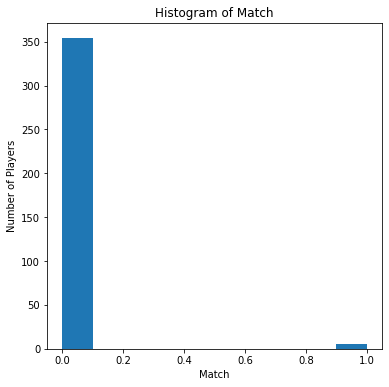

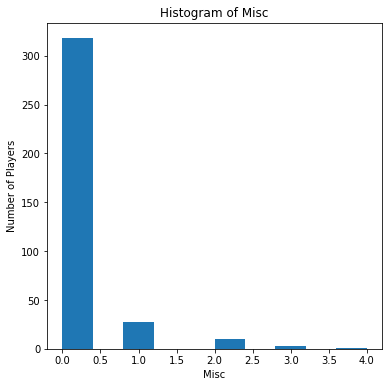

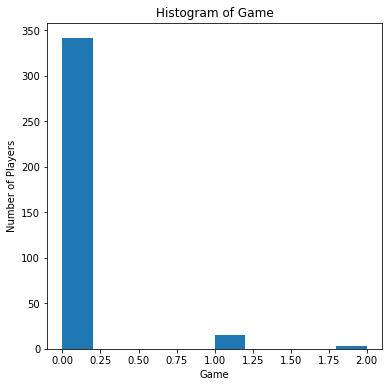

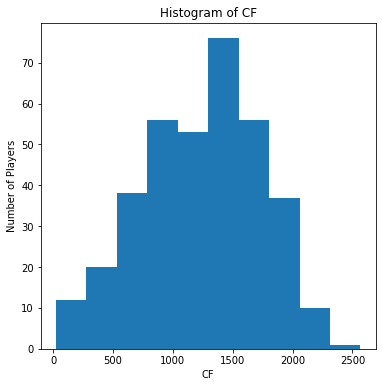

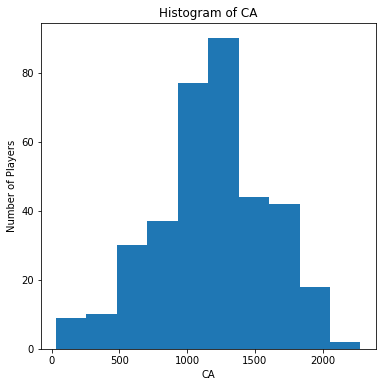

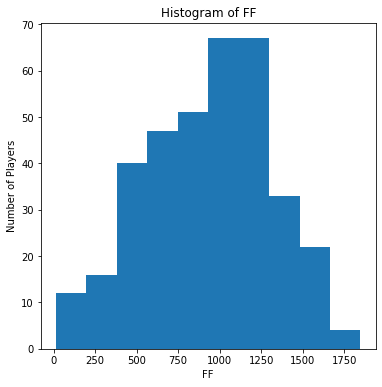

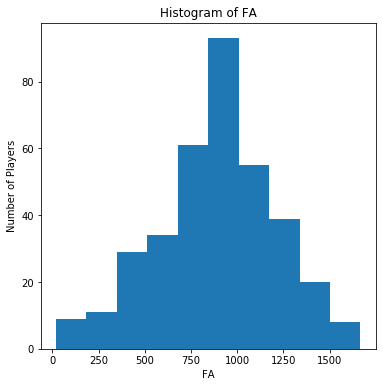

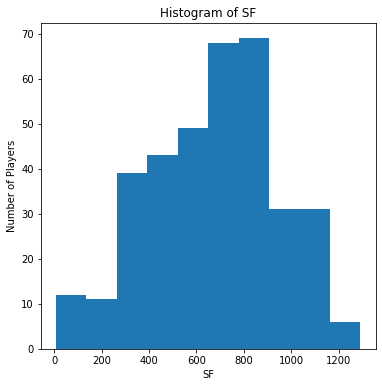

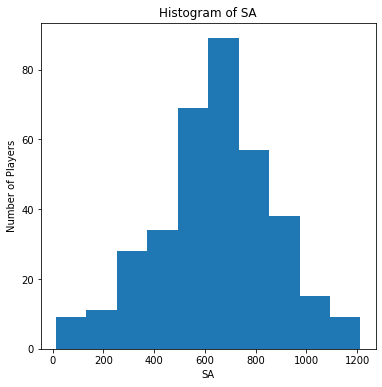

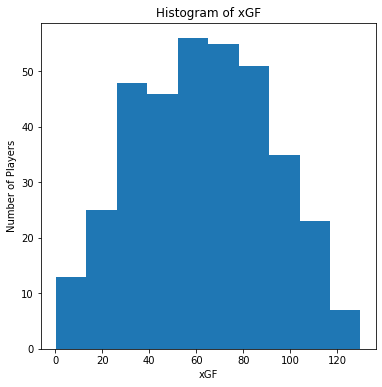

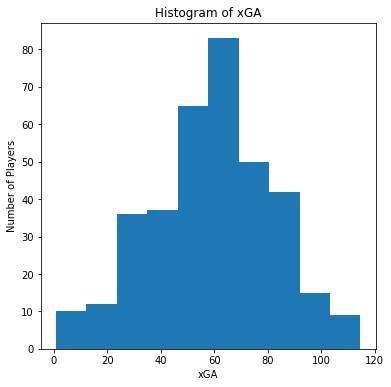

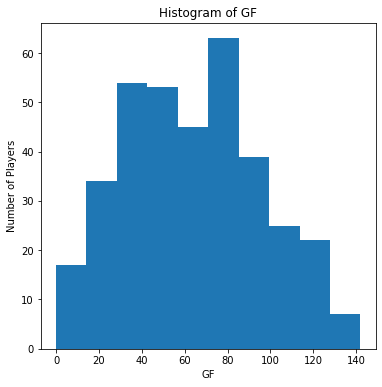

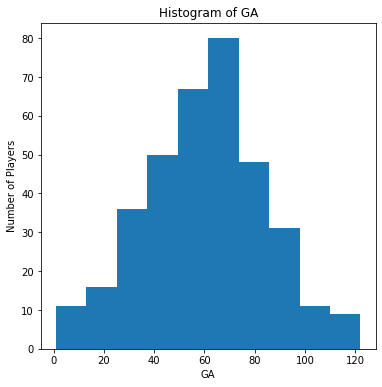

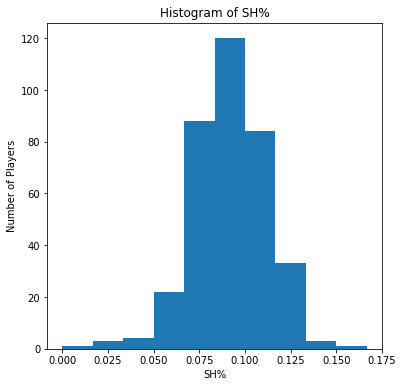

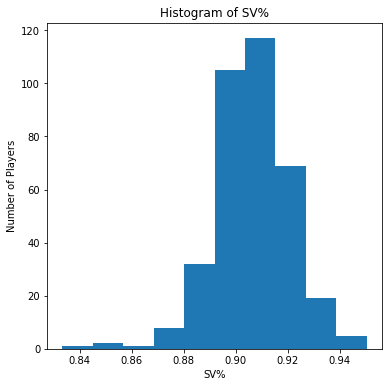

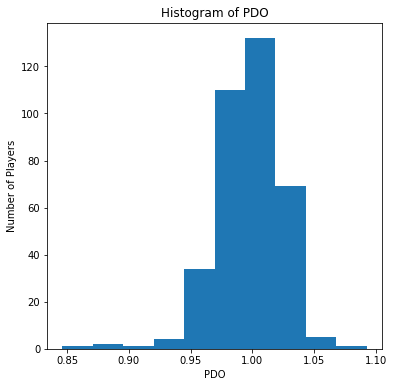

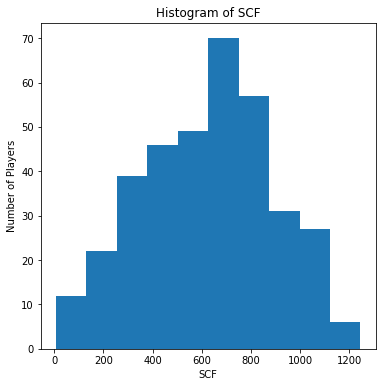

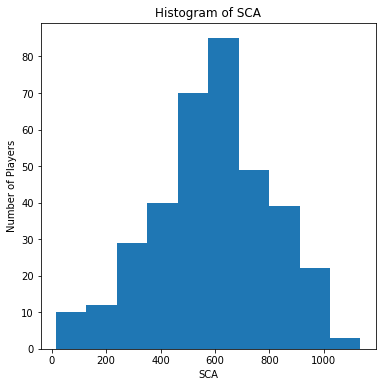

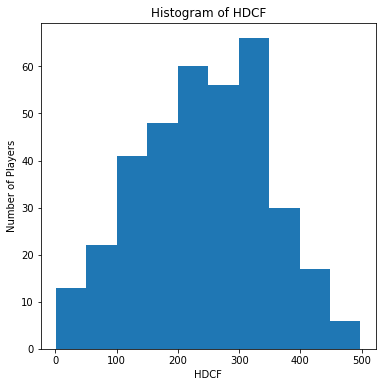

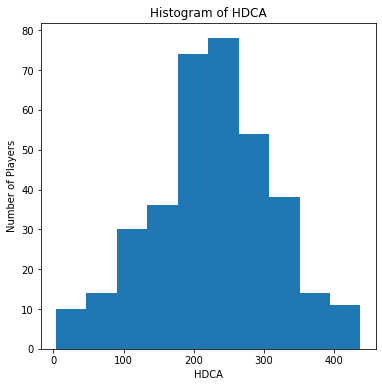

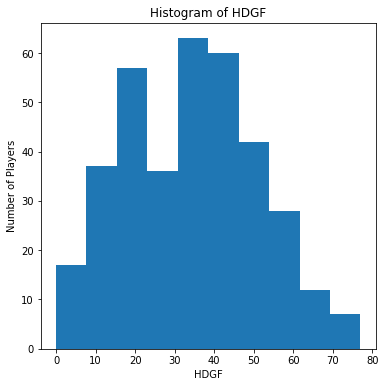

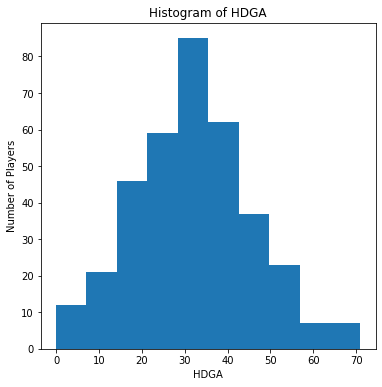

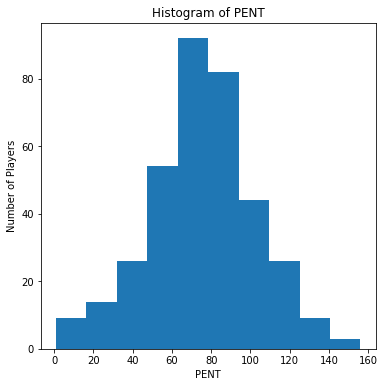

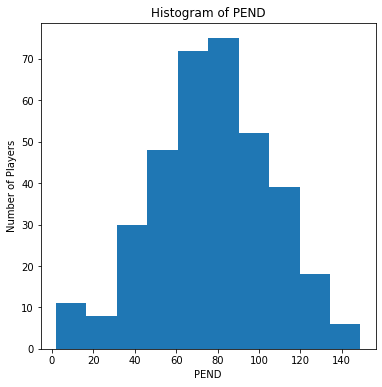

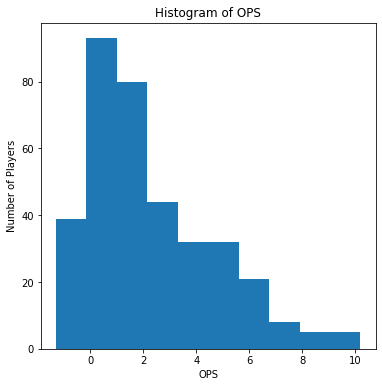

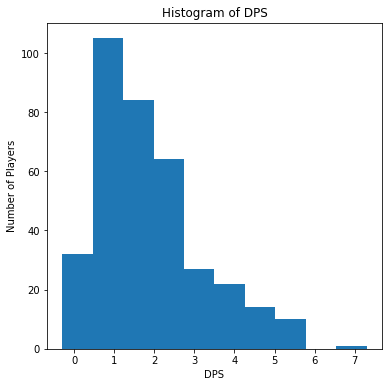

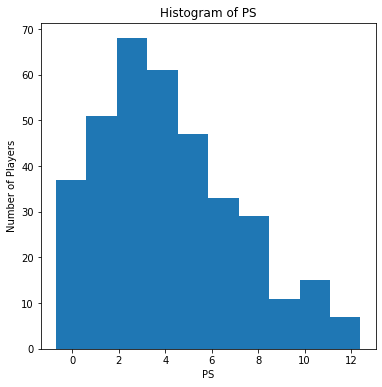

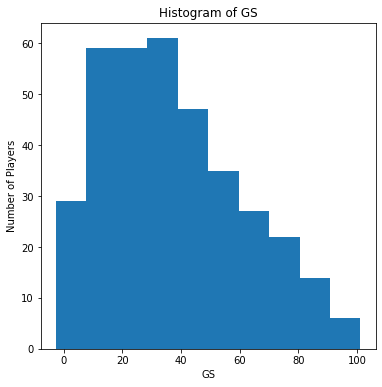

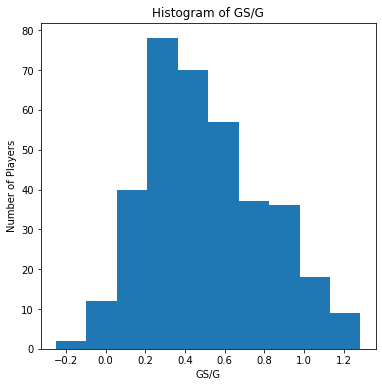

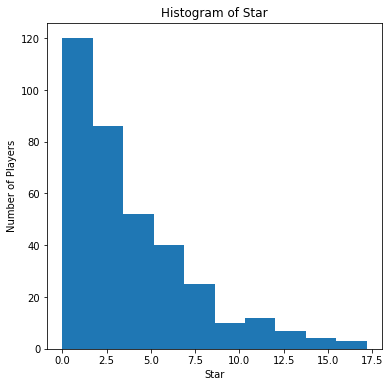

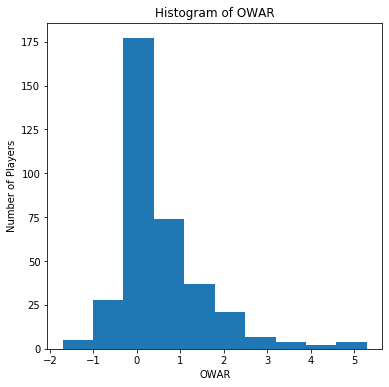

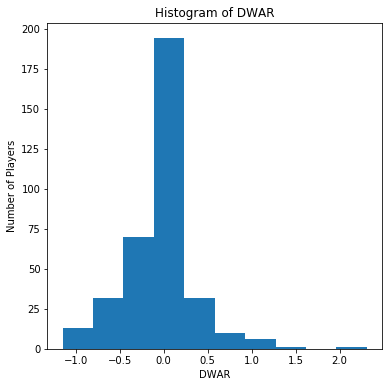

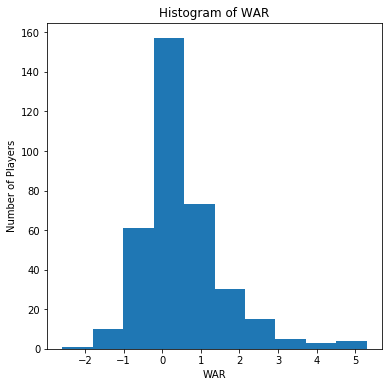

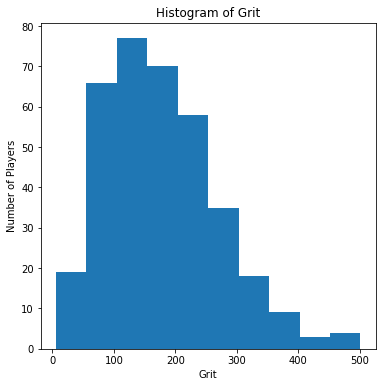

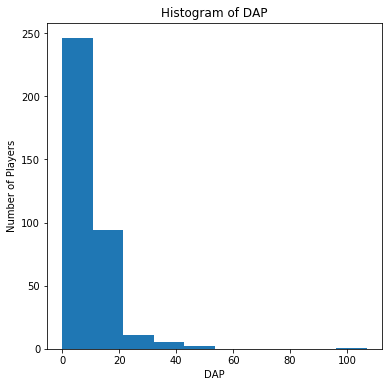

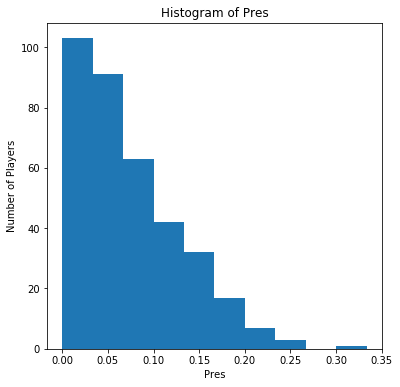

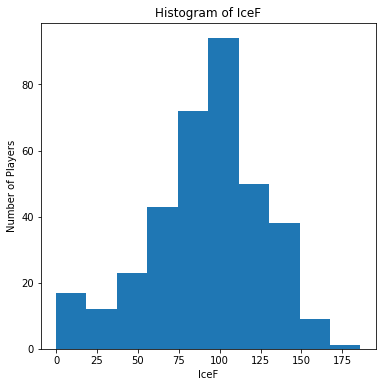

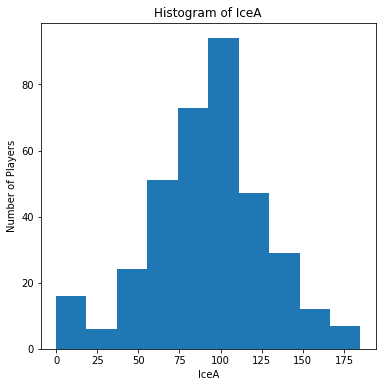

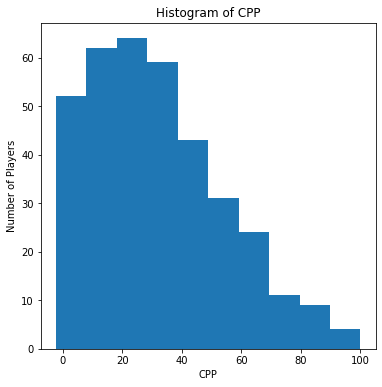

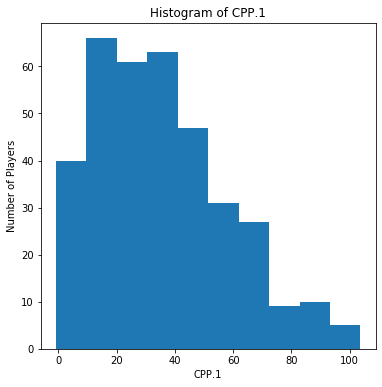

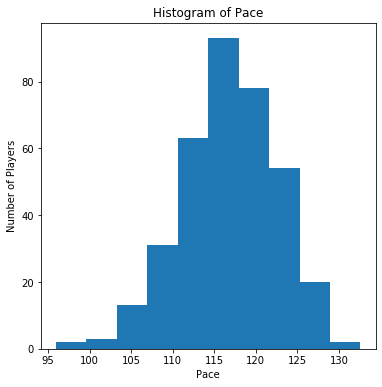

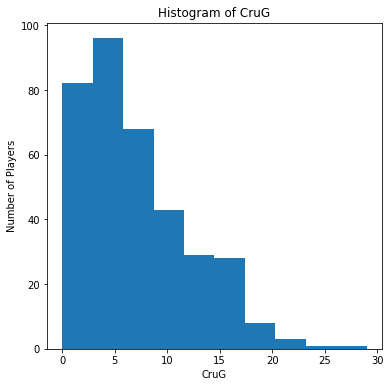

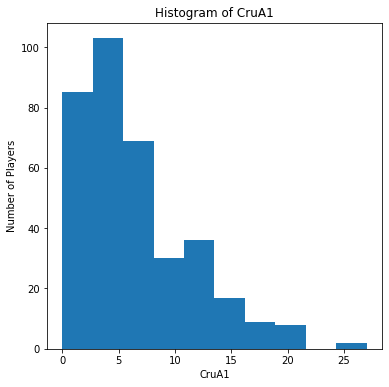

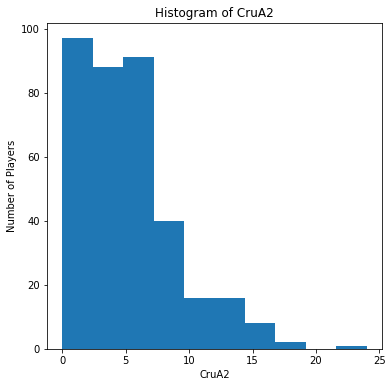

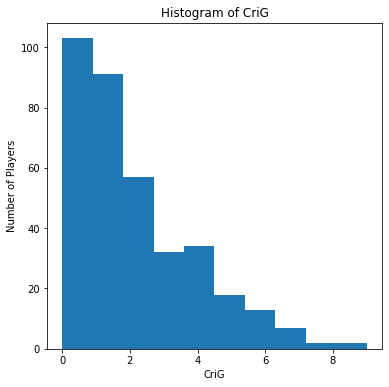

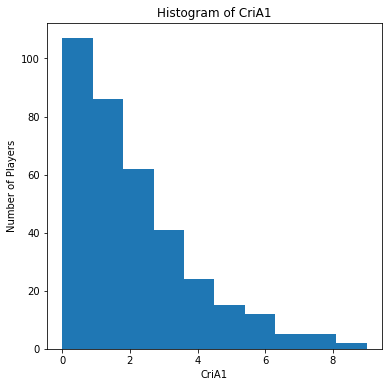

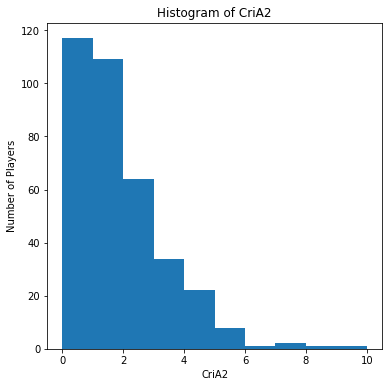

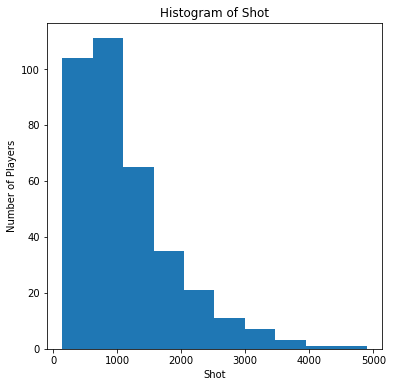

In [15]:
def plot_histogram(season18, cols, bins = 10):
    for col in cols:
        fig = plt.figure(figsize=(6,6)) # define plot area
        ax = fig.gca() # define axis    
        season18[col].plot.hist(ax = ax, bins = bins) # Use the plot.hist method on subset of the data frame
        ax.set_title('Histogram of ' + col) # Give the plot a main title
        ax.set_xlabel(col) # Set text for the x axis
        ax.set_ylabel('Number of Players')# Set text for y axis
        plt.show()
        
num_cols = list(modelSeason18X.columns)
plot_histogram(modelSeason18X, num_cols)

In [16]:
from sklearn import preprocessing

x = modelSeason18X.values
normalized = preprocessing.normalize(x)
modelSeason18X = pd.DataFrame(normalized)

In [17]:
#Backward Elimination
cols = list(modelSeason18X.columns)
pmax = 1
y=modelSeason18['Cap Hit']
count=0
while (len(cols)>0):
    if(count%100==0):
        print(count)
    count=count+1
    p= []
    X_1 = modelSeason18X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(list(y),X_1.astype(float)).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)  
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

0


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


100
[1, 4, 7, 8, 11, 12, 15, 19, 33, 36, 38, 39, 43, 44, 48, 88, 107, 109, 111, 113, 114, 117, 118, 126, 129, 131, 136, 138, 144]


In [18]:
season18.columns[selected_features_BE]

Index(['City', 'Nat', 'DftYr', 'DftRd', 'Debut', 'Age', 'CorsicaID',
       'Position', 'Shifts', 'TOI%', 'iCF', 'iFF', 'iRush', 'iReb', 'Pass',
       'G.Snap', 'iPenDf', 'Min', 'Match', 'Game', 'CF', 'FA', 'SF', 'PDO',
       'HDCF', 'HDGF', 'DPS', 'GS', 'SOS'],
      dtype='object')

In [19]:
len(selected_features_BE)

29

In [20]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

In [21]:
modelSeason18X=modelSeason18X[selected_features_BE]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(modelSeason18X,y, test_size = 0.2, random_state = 0)

In [23]:
#X2_train=X_train[[5, 8, 14, 15, 20, 21, 22, 27, 38, 39, 40, 42, 43, 51, 57, 85, 89, 90, 91, 94, 96, 104, 105, 107, 110, 118, 133, 136, 143]]
#y2_train=y_train.copy()
#X2_test=X_test[[5, 8, 14, 15, 20, 21, 22, 27, 38, 39, 40, 42, 43, 51, 57, 85, 89, 90, 91, 94, 96, 104, 105, 107, 110, 118, 133, 136, 143]]
#y2_test=y_test.copy()

In [24]:
reg = LassoCV()
reg.fit(X_train, y_train)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X_test,y_test))
coef = pd.Series(reg.coef_, index = X_test.columns)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 200113756779.8125, tolerance: 77817583161.92885
  tol, rng, random, positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 197718397600.59375, tolerance: 77817583161.92885
  tol, rng, random, positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of 

Best alpha using built-in LassoCV: 20.559650
Best score using built-in LassoCV: 0.568175


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 315109779487.4375, tolerance: 72603598501.76291
  tol, rng, random, positive)


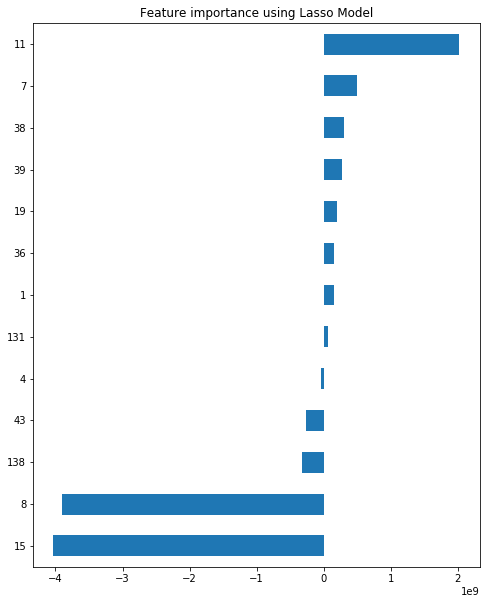

In [25]:
imp_coef = coef.sort_values()
imp_coef=imp_coef[imp_coef!=0]
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")
plt.show()

(array([ 3.,  1.,  4.,  4.,  9., 14., 20.,  4.,  9.,  4.]),
 array([-52962.4260259 , -43662.89527064, -34363.36451537, -25063.83376011,
        -15764.30300485,  -6464.77224958,   2834.75850568,  12134.28926095,
         21433.82001621,  30733.35077148,  40032.88152674]),
 <a list of 10 Patch objects>)

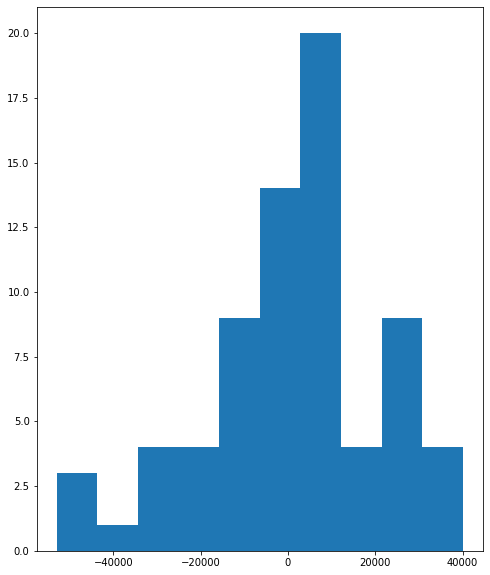

In [26]:
plt.hist((reg.predict(X_test)-y_test)/len(y_test))

(array([19., 14., 14.,  4.,  5.,  9.,  2.,  2.,  1.,  2.]),
 array([1.82950326e+00, 5.29788916e+03, 1.05939488e+04, 1.58900085e+04,
        2.11860681e+04, 2.64821278e+04, 3.17781874e+04, 3.70742471e+04,
        4.23703067e+04, 4.76663664e+04, 5.29624260e+04]),
 <a list of 10 Patch objects>)

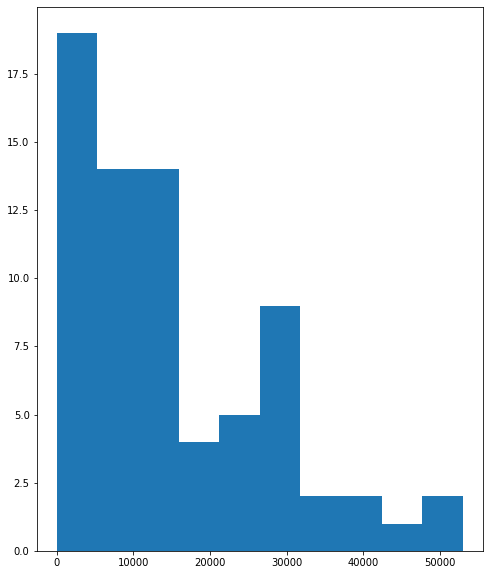

In [27]:
plt.hist((abs(reg.predict(X_test)-y_test))/len(y_test))

In [28]:
diff=reg.predict(X_test)-y_test
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))

-2615434.4066261104
315389.9765139064
2248211.962923879
25


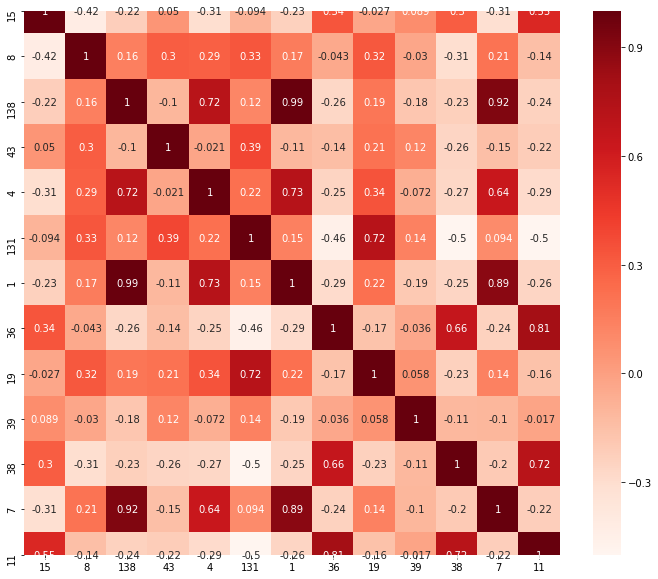

In [29]:
corr = modelSeason18X[imp_coef.index].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr.loc[corr.columns,corr.columns], annot=True, cmap=plt.cm.Reds)
plt.show()

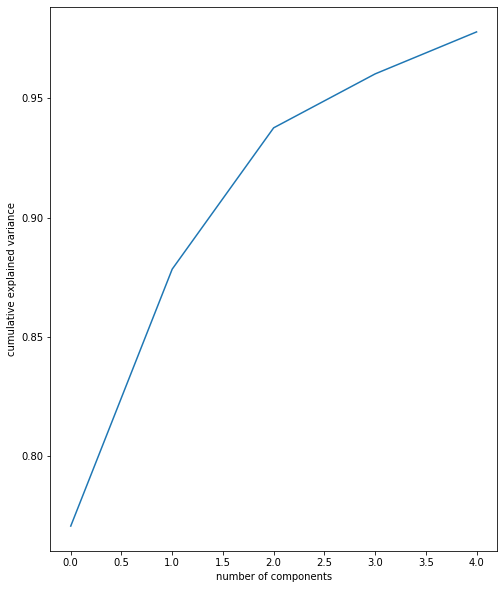

In [30]:
from sklearn.decomposition import PCA
pca = PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_)[0:5])
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [31]:
pca=PCA(2)
pca.fit(X_train)
pcatrain_x = pca.transform(X_train)
pcatest_x = pca.transform(X_test)
reg = LassoCV()
reg.fit(pcatrain_x, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [32]:
diff=reg.predict(pcatest_x)-y_test
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))

print(reg.score(pcatest_x, y_test))

-3743203.780041145
62668.87856177287
2677602.9778083777
14
0.2557592926794996


In [33]:
import xgboost as xgb
dtrain=xgb.DMatrix(X_train,y_train)
dtest=xgb.DMatrix(X_test,y_test)
params={
    'objective':"reg:squarederror",
    'eval_metric':["rmse","mae"]
}
evallist=[(dtest,'eval'),(dtrain,'train')]

In [34]:
num_round = 1000
bst=xgb.train(params,dtrain, num_round, evallist,early_stopping_rounds=10)

[0]	eval-rmse:3495903.50000	eval-mae:2955535.50000	train-rmse:3459602.25000	train-mae:3063741.00000
Multiple eval metrics have been passed: 'train-mae' will be used for early stopping.

Will train until train-mae hasn't improved in 10 rounds.
[1]	eval-rmse:2766301.75000	eval-mae:2186390.75000	train-rmse:2551315.00000	train-mae:2198033.25000
[2]	eval-rmse:2316656.00000	eval-mae:1782267.62500	train-rmse:1902827.62500	train-mae:1585248.50000
[3]	eval-rmse:2059139.25000	eval-mae:1550867.50000	train-rmse:1435431.12500	train-mae:1158116.50000
[4]	eval-rmse:1878999.50000	eval-mae:1405856.50000	train-rmse:1090352.87500	train-mae:849112.18750
[5]	eval-rmse:1774419.12500	eval-mae:1345719.50000	train-rmse:848216.06250	train-mae:631082.87500
[6]	eval-rmse:1692417.12500	eval-mae:1285071.50000	train-rmse:672953.50000	train-mae:482862.59375
[7]	eval-rmse:1635733.87500	eval-mae:1250253.87500	train-rmse:525585.25000	train-mae:369023.68750
[8]	eval-rmse:1620091.62500	eval-mae:1241140.50000	train-rmse:42

[84]	eval-rmse:1577575.50000	eval-mae:1213697.87500	train-rmse:241.37293	train-mae:170.66855
[85]	eval-rmse:1577576.87500	eval-mae:1213697.87500	train-rmse:230.72786	train-mae:164.22649
[86]	eval-rmse:1577575.75000	eval-mae:1213697.62500	train-rmse:217.99048	train-mae:157.78876
[87]	eval-rmse:1577577.00000	eval-mae:1213696.12500	train-rmse:205.51897	train-mae:147.36629
[88]	eval-rmse:1577572.37500	eval-mae:1213689.37500	train-rmse:182.75182	train-mae:131.53093
[89]	eval-rmse:1577573.25000	eval-mae:1213691.50000	train-rmse:166.88301	train-mae:120.42857
[90]	eval-rmse:1577572.87500	eval-mae:1213690.25000	train-rmse:160.71782	train-mae:114.77134
[91]	eval-rmse:1577573.37500	eval-mae:1213691.50000	train-rmse:148.20534	train-mae:104.98563
[92]	eval-rmse:1577574.12500	eval-mae:1213688.75000	train-rmse:141.55121	train-mae:99.18380
[93]	eval-rmse:1577572.50000	eval-mae:1213686.75000	train-rmse:135.93979	train-mae:94.06576
[94]	eval-rmse:1577573.25000	eval-mae:1213686.25000	train-rmse:121.51726

Stopping. Best iteration:
[164]	eval-rmse:1577576.00000	eval-mae:1213689.25000	train-rmse:0.66517	train-mae:0.47343



In [35]:
xgbPred=bst.predict(dtest,ntree_limit=bst.best_ntree_limit)

In [36]:
diff=xgbPred-y_test
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))


-2717598.0
164325.75
2731004.75
20


In [37]:
from sklearn.metrics import mean_squared_error
mean_squared_error(xgbPred,y_test)

2488745319165.4727

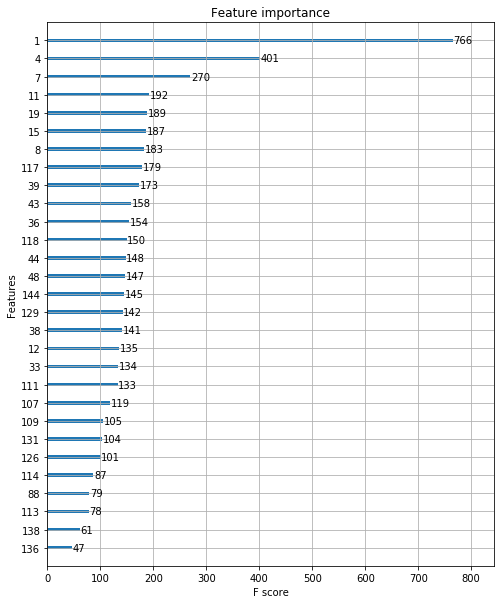

In [38]:
xgb.plot_importance(bst)

(array([ 5.,  4., 12., 15., 16., 10.,  5.,  2.,  0.,  3.]),
 array([-3.1251195 , -2.35686895, -1.5886184 , -0.82036785, -0.0521173 ,
         0.71613325,  1.4843838 ,  2.25263435,  3.0208849 ,  3.78913545,
         4.557386  ]),
 <a list of 10 Patch objects>)

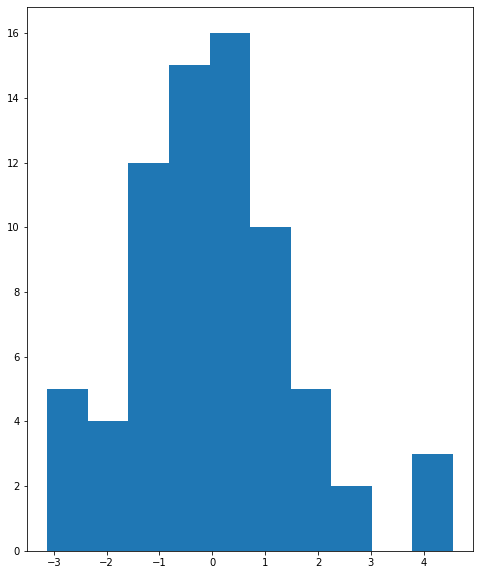

In [39]:
plt.hist((y_test.subtract(xgbPred))/1000000)

In [40]:
diff=y_test.subtract(xgbPred)
len(diff[abs(diff)<500000])

20

In [41]:
len(diff)

72

In [42]:
from sklearn.tree import DecisionTreeRegressor

dtree=DecisionTreeRegressor()
#dtree.fit(X2_train,y2_train)
dtree.fit(X_train,y_train)

#diff=dtree.predict(X2_test)-y2_test
diff=dtree.predict(X_test)-y_test
diff=diff.sort_values()
diff=diff.reset_index(drop=True)

(array([ 2.,  2.,  6., 15., 12., 21.,  9.,  3.,  1.,  1.]),
 array([-4000000., -3160000., -2320000., -1480000.,  -640000.,   200000.,
         1040000.,  1880000.,  2720000.,  3560000.,  4400000.]),
 <a list of 10 Patch objects>)

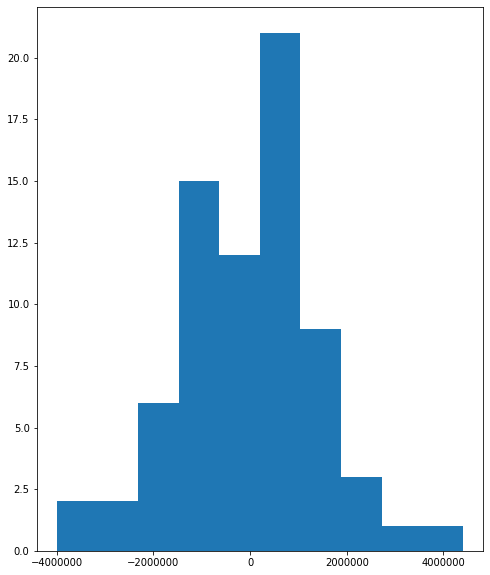

In [43]:
plt.hist(diff)

In [44]:
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))

-2575000.0
150000.0
2416666.0
14


In [45]:
from sklearn.svm import SVR
svr = SVR(kernel='rbf')
svr.fit(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [46]:
diff=svr.predict(X_test)-y_test
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
sum(diff)/len(y_test)

-34228.18348603844

In [47]:
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))

-4750000.100113407
149999.89974614233
3099999.899787943
21


In [48]:
len(diff[abs(diff)<500000])/len(diff)

0.2916666666666667

In [49]:
from sklearn.linear_model import SGDRegressor

sgd=SGDRegressor(max_iter=1000, tol=1e-3)
sgd.fit(X_train,y_train)
sgd.score(X_test,y_test)

1.9023994644262743e-05

In [50]:
diff=sgd.predict(X_test)-y_test
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))

-4694448.131880008
205291.27292127348
3155327.591387757
20


In [51]:
from sklearn.ensemble import BaggingRegressor

model = BaggingRegressor()
model.fit(X_train,y_train)

diff=model.predict(X_test)-y_test
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))

print(model.score(X_test,y_test))

-2410000.0
205000.0
2330000.0
22
0.5580753768168041


(array([ 2.,  1.,  2.,  7., 10., 11., 15., 12.,  5.,  7.]),
 array([-4.00105560e+06, -3.33361671e+06, -2.66617782e+06, -1.99873893e+06,
        -1.33130004e+06, -6.63861150e+05,  3.57774000e+03,  6.71016630e+05,
         1.33845552e+06,  2.00589441e+06,  2.67333330e+06]),
 <a list of 10 Patch objects>)

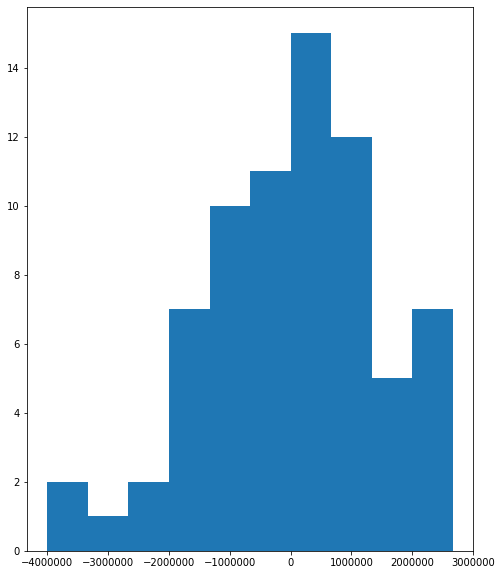

In [52]:
plt.hist(diff)

In [53]:
np.std(diff)

1435091.8246662777

In [55]:
model = BaggingRegressor()
model.fit(X_train,y_train)

diff=model.predict(X_test)-y_test
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))

print(model.score(X_test,y_test))

-2468333.3
63333.299999999814
2040833.2999999998
22
0.5645493980298414


(array([ 3.,  0.,  3.,  9.,  6., 14., 13.,  8., 10.,  6.]),
 array([-3795833.3 , -3165409.97, -2534986.64, -1904563.31, -1274139.98,
         -643716.65,   -13293.32,   617130.01,  1247553.34,  1877976.67,
         2508400.  ]),
 <a list of 10 Patch objects>)

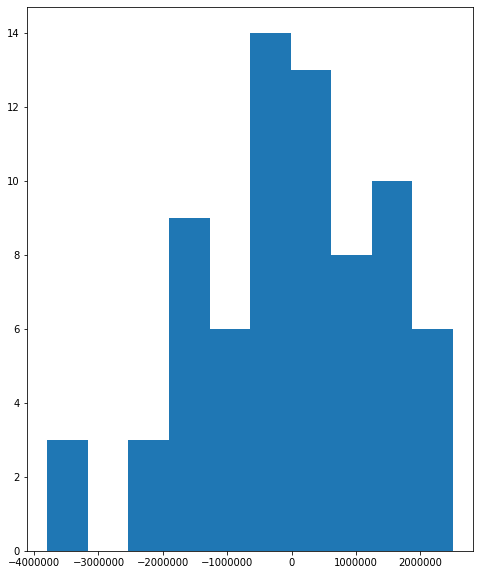

In [56]:
plt.hist(diff)

In [57]:
from sklearn.neural_network import MLPRegressor
regr = MLPRegressor(random_state=1, max_iter=1000000).fit(X_train, y_train)
regr.predict(X_test)
regr.score(X_test, y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.10928113474508182

In [58]:
diff=regr.predict(X_test)-y_test
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))

-4573010.019937522
141228.7953425385
3038016.373352288
23


In [ ]:
def bs(model):
    n_iterations = 1000
    n_size = int(len(data) * 0.50)
    # run bootstrap
    stats = list()
    for i in range(n_iterations):
        # prepare train and test sets
        train = resample(values, n_samples=n_size)
        test = numpy.array([x for x in values if x.tolist() not in train.tolist()])
        # fit model
        #model = DecisionTreeClassifier()
        model.fit(train[:,:-1], train[:,-1])
        # evaluate model
        predictions = model.predict(test[:,:-1])
        score = accuracy_score(test[:,-1], predictions)
        print(score)
        stats.append(score)

    # plot scores
    pyplot.hist(stats)
    pyplot.show()
    # confidence intervals
    alpha = 0.95
    p = ((1.0-alpha)/2.0) * 100
    lower = max(0.0, numpy.percentile(stats, p))
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = min(1.0, numpy.percentile(stats, p))
    print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))